In [1]:
import numpy as np
import itertools
import h5py
from copy import copy

from scipy import signal, interpolate

import matplotlib.pyplot as plt
from matplotlib import colors
import itertools

import re

from copy import copy, deepcopy

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session

In [2]:
%load_ext autoreload
%autoreload 1
%aimport process_imu

# Load data

Get data out of HDF5 file.  Convert time to seconds

In [3]:
calibfilename = '/Users/etytel01/Documents/Acceleration/rawdata/two_imu_data/data_b_1.hdf5'

In [4]:
filename = '/Users/etytel01/Documents/Acceleration/rawdata/two_imu_data/data_b_2.hdf5'
encoderfilename = ''

In [5]:
enc = None
mag = None
with h5py.File(filename, 'r') as h5file:
    if '/data/Mag' in h5file:
        mag = np.array(h5file['/data/Mag'])
    acc = np.array(h5file['/data/Accel'])
    accbase = np.array(h5file['/data/Accel2'])
    if '/data/Encoder' in h5file:
        print "Encoder data loaded from h5 file"
        enc = np.array(h5file['/data/Encoder'])

    t = np.array(h5file['/data/t'])
    
t = t/1000.0

if enc is None:
    enc = np.loadtxt(encoderfilename)
    print "Encoder data loaded from dat file"

Encoder data loaded from h5 file


# Show the data

Magnetometer data, if it's in the file

In [6]:
if mag is not None:
    fig, ax = plt.subplots(3,1, sharey=True, sharex=True)
    
    for ax1, mag1, lab1 in zip(ax, np.rollaxis(mag,1), ['X','Y','Z']):
        ax1.plot(t, mag1)
        ax1.set_ylabel(lab1)
    ax[0].set_title('Magnetometer')
    ax[0].set_ylim([-80, 80])
    plt.show()

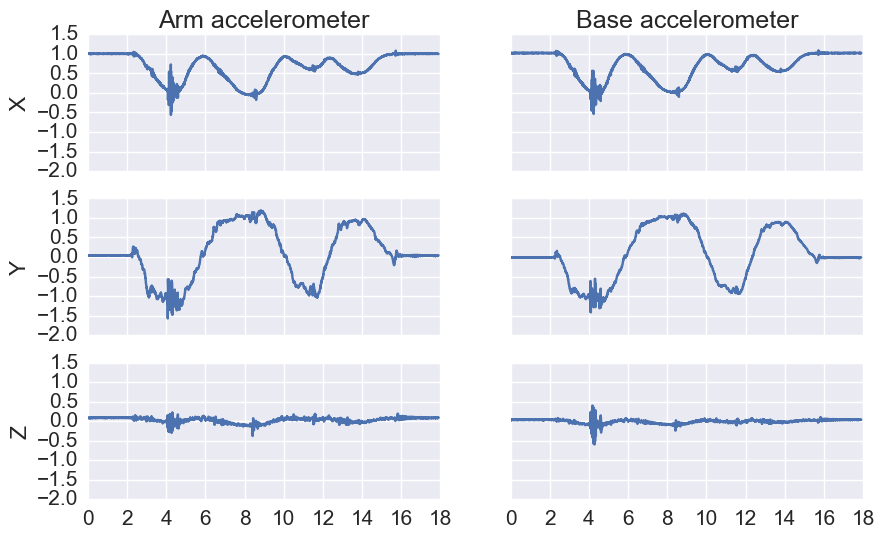

In [7]:
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)

for ax1, acc1, acc2, lab1 in zip(ax, np.rollaxis(acc,1), np.rollaxis(accbase,1), ['X','Y','Z']):
    ax1[0].plot(t, acc1)
    ax1[0].set_ylabel(lab1)
    ax1[1].plot(t, acc2)
    
ax[0,0].set_title('Arm accelerometer')
ax[0,1].set_title('Base accelerometer')
plt.show()

Show encoder, if it's available

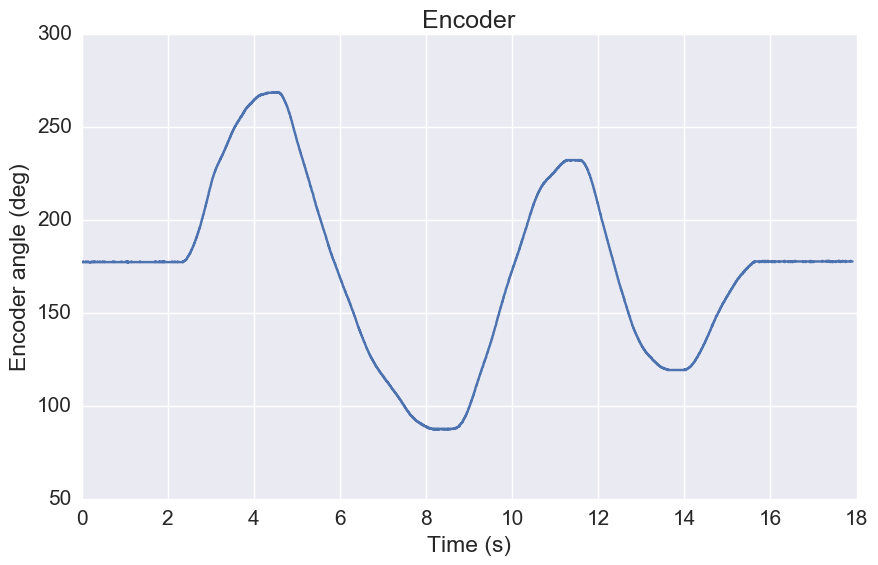

In [8]:
if enc is not None:
    fig, ax = plt.subplots()
    ax.plot(t, enc)
    ax.set_ylabel('Encoder angle (deg)')
    ax.set_xlabel('Time (s)')
    ax.set_title('Encoder')
    plt.show()

# Process the data

Loads the data into the IMU object, calibrates the covariance matrices.

Assumes that the initial position of the IMU in the calibration file is the orientation we want to use as the inertial frame of reference.  (will need to change this when dealing with fish data)

In [99]:
imu = process_imu.IMU()
imu.calibrate(calibfilename)
imu.get_inertial_coords(calibfilename)

In [100]:
imu.load(filename, resamplefreq=200.0)
imu.filter(order=5, gyro_cutoff=[10.0], acc_cutoff=[10.0])

## Set up different levels of Ca parameter to test

In [101]:
lCa = [-3, 0, 2]

In [102]:
imu_mad = imu
imu_ekf = [copy(imu) for _ in lCa]

In [103]:
orient_ekf = []
accdyn_ekf = []
ekf_label = []
for lCa1, imu_ekf1 in zip(lCa, imu_ekf):
    imu_ekf1.get_orientation(method='ekf', lCa=(lCa1, lCa1, lCa1))
    
    orient_ekf.append(imu_ekf1.orient)
    accdyn_ekf.append(imu_ekf1.accdyn)
    ekf_label.append('EKF lCa={}'.format(lCa1))

imu_mad.get_orientation(method='madgwick')
orient_mad = imu_mad.orient
accdyn_mad = imu_mad.accdyn

Merge all the different estimates

In [104]:
orient = np.append(orient_mad[np.newaxis, :, :], np.array(orient_ekf), axis=0)
accdyn = np.append(accdyn_mad[np.newaxis, :, :], np.array(accdyn_ekf), axis=0)
label = ['mad'] + ekf_label

Interpolate the encoder data and the base accelerometer on to the same time as the IMU

In [105]:
t0 = t
t = imu.t
enc = interpolate.interp1d(t0, enc)(t)
accbase = interpolate.interp1d(t0, accbase, axis=0)(t)

Compare yaw, which is the axis for which the encoder gives us data.

I think this should be true whether or not the rig was mounted horizontally or vertically, because the chip was always mounted with the z axis in the same plane as the encoder.  But we should check true yaw, meaning rotation about the gravitational vector, for vertical plane tests, because that may drift

In [106]:
enc -= enc[0]

In [107]:
yawerr = enc[np.newaxis, :] - np.rad2deg(orient[:, :, 2])

In [108]:
yawerrrms = np.sqrt(np.mean(yawerr**2, axis=1))

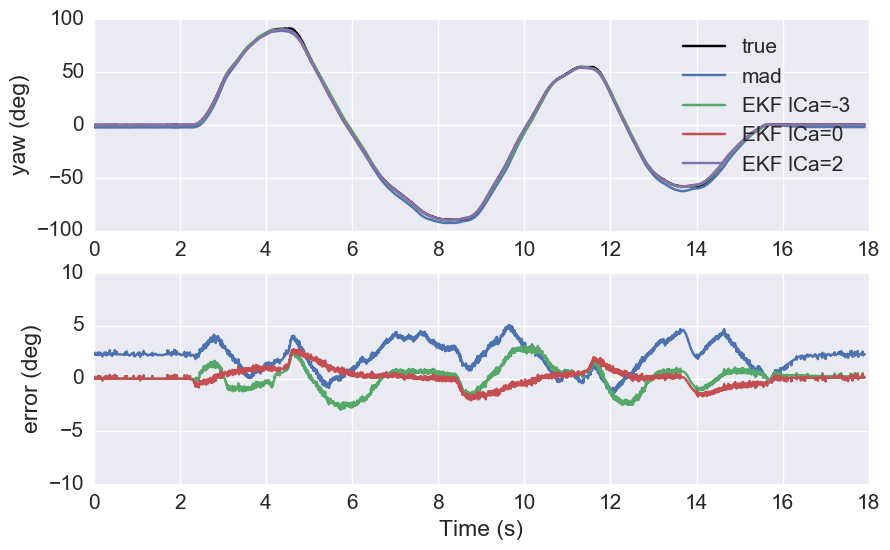

In [109]:
fig, ax = plt.subplots(2,1)
ax[0].plot(t, enc, 'k-', label='true')
for o1, lab1 in zip(orient, label):
    ax[0].plot(imu.t, np.rad2deg(o1[:, 2]), label=lab1)
ax[0].legend()
ax[0].set_ylabel('yaw (deg)')

for err1, lab1 in zip(yawerr, ekf_label):
    ax[1].plot(imu.t, err1, label=lab1)
ax[1].set_ylabel('error (deg)')
ax[1].set_ylim([-10, 10])

ax[1].set_xlabel('Time (s)')

plt.show()

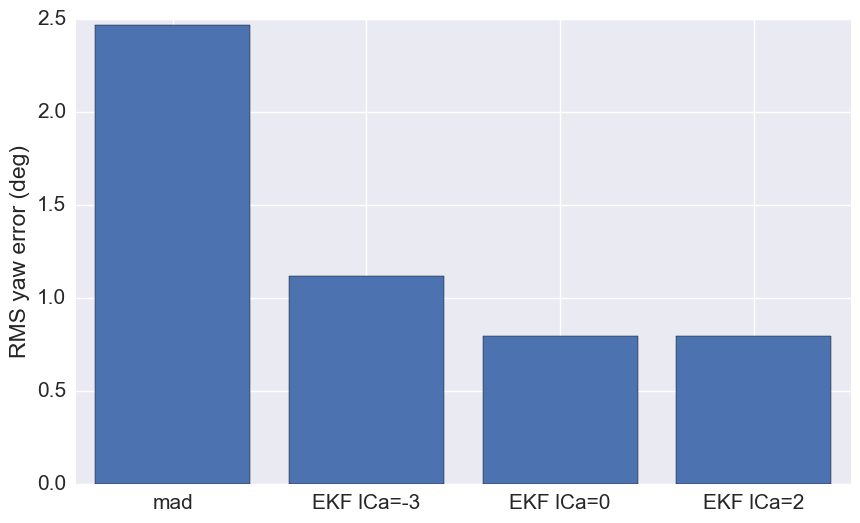

In [110]:
fig, ax = plt.subplots()

ax.bar(range(len(yawerrrms)), yawerrrms, align='center')
ax.set_xticks(range(len(yawerrrms)))
ax.set_xticklabels(label)

ax.set_ylabel('RMS yaw error (deg)')
plt.show()

TypeError: list indices must be integers, not tuple

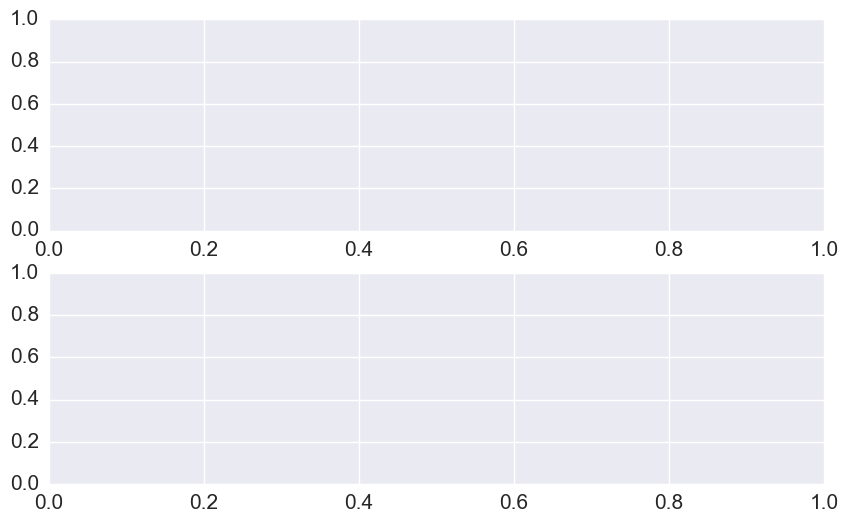

In [111]:
fig, ax = plt.subplots(2,1)
for ax1, oe, om, lab1 in zip(ax, np.rollaxis(orient_ekf[:,:-1], 1), np.rollaxis(orient_mad[:,:-1], 1), ['roll','pitch']):
    ax1.plot(imu.t, np.rad2deg(oe), label='EKF')
    ax1.plot(imu.t, np.rad2deg(om-om[0]), '--', label='mad')
    ax1.set_ylabel(lab1)
ax[0].legend()
plt.show()

# Dynamic acceleration

First need to account for the acceleration due to the arm's angular movement

In [43]:
enc[:5] = enc[5]

In [44]:
armlen = 50.5         # cm

In [45]:
dt = t[1]-t[0]
window_dur = 0.3

angaccel = np.deg2rad(signal.savgol_filter(enc, window_length=2*int(window_dur/dt/2)+1, polyorder=3, deriv=2)) / dt**2
rotaccel = np.vstack((armlen*angaccel*np.cos(np.deg2rad(enc)), 
                      armlen*angaccel*np.sin(np.deg2rad(enc)), np.zeros_like(t))).T

# convert to m/s^2
rotaccel = rotaccel / 100.0

linaccel_ekf = accdyn_ekf - rotaccel
linaccel_mad = accdyn_mad - rotaccel

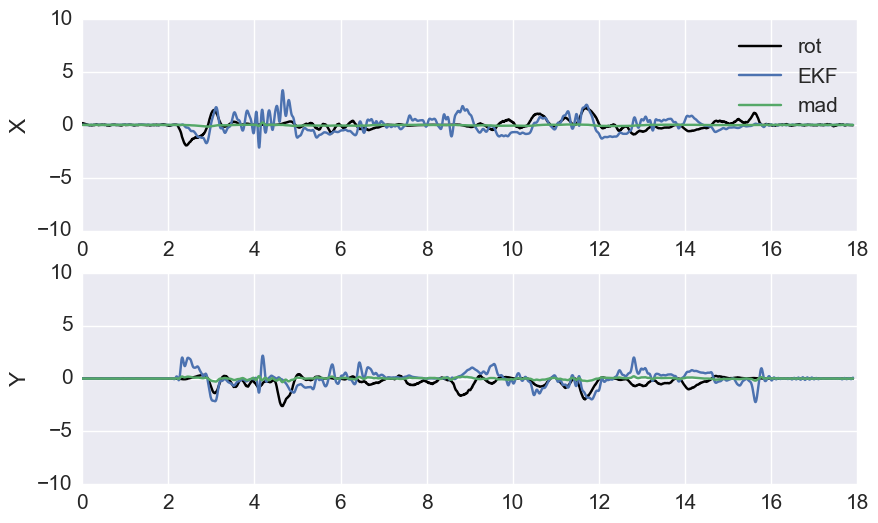

In [46]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(t, rotaccel[:, 0], 'k', label='rot')
ax[0].plot(t, accdyn_ekf[:, 0], label='EKF')
ax[0].plot(t, accdyn_mad[:, 0], label='mad')
ax[0].set_ylim([-10, 10])
ax[0].set_ylabel('X')
ax[0].legend()

ax[1].plot(t, -rotaccel[:, 1], 'k', label='rot')
ax[1].plot(t, accdyn_ekf[:, 1], label='EKF')
ax[1].plot(t, accdyn_mad[:, 1], label='mad')
ax[1].set_ylim([-10, 10])
ax[1].set_ylabel('Y')

plt.show()

In cases with linear motion, the dynamic acceleration estimated from the arm accelerometer should the acceleration measured on the base.  When the IMU was on the base of the arm, we'll need to subtract out the arm rotation

First get the orientation of the base IMU.  If the base IMU is actually mounted on the base, then this will just be [1, 0, 0] repeated a bunch of times

In [47]:
gbase = np.vstack((np.cos(np.deg2rad(180.0 - enc)), np.sin(np.deg2rad(180.0 - enc)), np.zeros_like(enc))).T

Then dynamic acceleration of the base.  Assume rotational velocities are very low, since it's on the base

In [48]:
accdynbase = accbase - gbase

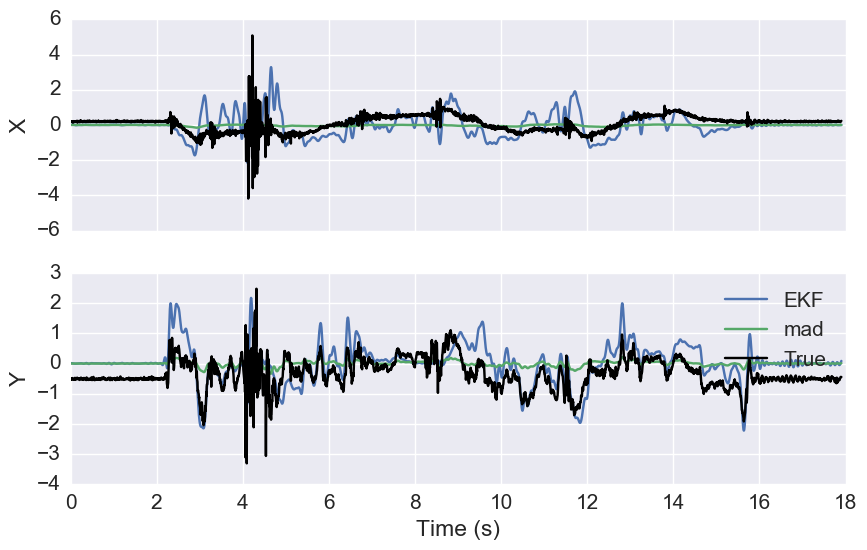

In [49]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(imu.t, accdyn_ekf[:, 0], label='EKF')
ax[0].plot(imu.t, accdyn_mad[:, 0], label='mad')
ax[0].plot(imu.t, accdynbase[:, 0]*9.81, 'k-')
ax[0].set_ylabel('X')

ax[1].plot(imu.t, accdyn_ekf[:, 1], label='EKF')
ax[1].plot(imu.t, accdyn_mad[:, 1], label='mad')
ax[1].plot(imu.t, accdynbase[:, 1]*9.81, 'k-', label='True')
ax[1].set_ylabel('Y')
ax[1].legend()

ax[1].set_xlabel('Time (s)')
plt.show()